In [2894]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from sqlite3 import Error

resultDir= "examples/unicast"
simScenarioNetworkName="SimpleNetwork2"
repeatCount=10


scenarioExt="allApps-Final"


def getScalarValueFromDB(dbConnexion, query):
    cursor=dbConnexion.cursor()
    cursor.execute(query)
    return cursor.fetchone()[0]

def getDBPath(scenario,offeredLoadRate,repeatID):
    tmp= resultDir+"/"+scenario+"-"+scenarioExt+"/"+scenario+"-OfferedLoadRate="+str(offeredLoadRate);
    tmp+=",nbrTrs=24,bitrate=24,LTEcqi=8,packetLength=200,simArea=50,repeatID="+str(repeatID)+"-#0.sca"
    
    return tmp

def getAppsOrConditionList(commonPrefix,appIDs):
    rStr="";
    for appID in appIDs:
        rStr+= "moduleName like '"+commonPrefix+"applLayer["+str(appID)+"]' OR "
    return rStr[0:len(rStr)-3]

def getThroughputMeanAndStd(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs):
    def getThroughput(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs):
        dbPath=getDBPath(scenario,OfferedLoadRate,repeatID)
        dbConn = sqlite3.connect(dbPath)
        tmpList=[]
        for moduleIndex in range(nodeIndexStart,nodeIndexEnd):
            query="SELECT avg(v.scalarValue)*0.000001 FROM scalar v where v.scalarName='throughput:mean'"+\
            "and v.scalarValue NOT NULL AND (" + getAppsOrConditionList("%node["+str(shiff+moduleIndex)+"].",appIDs)+")"
            # times 0.000001 in the query is to convert from bps to mbps 
            queryResult=getScalarValueFromDB(dbConn, query)
            if queryResult is not None:
                tmpList.append(queryResult)
        return np.mean(tmpList)*((nodeIndexEnd-nodeIndexStart)+1) # the multiplication is to get the total throughput of the 10 node peers
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getThroughput(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs))
    return [np.mean(values),np.std(values)]     


def getDelayMeanAndStd(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs):
    def getDelay(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs):
        dbPath=getDBPath(scenario,OfferedLoadRate,repeatID)
        #print(dbPath)
        dbConn = sqlite3.connect(dbPath)
        tmpList=[]
        for moduleIndex in range(nodeIndexStart,nodeIndexEnd):
            query="SELECT avg(v.scalarValue)*1000 FROM scalar v where v.scalarName='delay:mean' and "+\
            "v.scalarValue NOT NULL AND ("+ getAppsOrConditionList("%node["+str(shiff+moduleIndex)+"].",appIDs)+")"
             # times 1000 in the query is to convert from secand to millisecond
            queryResult=getScalarValueFromDB(dbConn, query)
            if queryResult is not None:
                tmpList.append(queryResult)
            #print(query)
            #print(queryResult)
        return np.mean(tmpList)
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getDelay(scenario,OfferedLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs))
    return [np.mean(values),np.std(values)]  


def getReliabilityMeanAndStd(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs):
    def getReliability(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs):
        dbPath=getDBPath(scenario,offeredLoadRate,repeatID)
        dbConn = sqlite3.connect(dbPath)
        #print(dbPath)
        tmpList=[]
        for moduleIndex in range(nodeIndexStart,nodeIndexEnd):
            sentPkQuery = "SELECT scalarValue FROM scalar WHERE scalarName='sentPk:count' "+\
            "AND ("+getAppsOrConditionList("%node["+str(moduleIndex)+"].",appIDs)+")"
            rcvdPkQuery = "SELECT scalarValue FROM scalar WHERE scalarName='rcvdPk:count' "+\
            "AND ("+getAppsOrConditionList("%node["+str(shiff+moduleIndex)+"].",appIDs)+")"
            #print(sentPkQuery)
            sentPk = getScalarValueFromDB(dbConn, sentPkQuery)
            #print(rcvdPkQuery)
            rcvdPk = getScalarValueFromDB(dbConn, rcvdPkQuery)
            
            if rcvdPk is not None:
                assert sentPk > 0 
                tmpList.append(rcvdPk/sentPk)

        return np.mean(tmpList)
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getReliability(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,repeatID,appIDs))
    return [np.mean(values)*100,np.std(values)*100]  # times *100 to convert to %


def plotResult2(scenario, subScenarios,nodeInGroupNbr,shiff,appIDs):
    
    scenarioLabels=["DURATS","DURATS-Simple","RandomDecision","FixedDecision"]
    
    xPlotCord = 0
    yPlotCord = 0
    # Initialise the subplot function using number of rows and columns
    fig,ax = plt.subplots(3,1,figsize=(4,8))
    
    labelIndex =0
    for nodeIndexStart in subScenarios:
        nodeIndexEnd=nodeIndexStart+nodeInGroupNbr
        for resultTypeCode in range(0,3):
            
            ylabelTitle=""
            scenarioData=[]
            scenarioYerr=[]
            baselineData=[]
            baselineYerr=[] 
            offeredLoadRates =[]
            xPlotCord=resultTypeCode
            
            if resultTypeCode == 0 :
                ylabelTitle="Delay (ms)"
                for offeredLoadRate in range(20,101,20):
                    offeredLoadRates.append(offeredLoadRate)
                    tmp = getDelayMeanAndStd(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
            elif resultTypeCode == 1 :
                ylabelTitle="Throughput (Mbps)"
                for offeredLoadRate in range(20,101,20):
                    offeredLoadRates.append(offeredLoadRate)
                    tmp = getThroughputMeanAndStd(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
            elif resultTypeCode == 2 :
                ylabelTitle="Packet delivery rate (%)"
                for offeredLoadRate in range(20,101,20):
                    offeredLoadRates.append(offeredLoadRate)
                    tmp = getReliabilityMeanAndStd(scenario,offeredLoadRate,nodeIndexStart,nodeIndexEnd,shiff,appIDs)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
            
            legendLable="node["+str(nodeIndexStart)+"-"+str(nodeIndexEnd-1)+"]"
            ax[xPlotCord].errorbar(offeredLoadRates,scenarioData,yerr=scenarioYerr,label=scenarioLabels[labelIndex])
            #ax[xPlotCord, yPlotCord].set_title("["+str(offeredLoadRate)+"%"" decision traffic load]")
            ax[xPlotCord].set_ylabel(ylabelTitle)
            handles, labels = ax[xPlotCord].get_legend_handles_labels()
        
        labelIndex +=1
        
    fig.tight_layout(pad=1.0)
    
    lgd=fig.legend(labels, loc='upper center', bbox_to_anchor=(0.55, 1.05), ncol=2)
    #fig.text(0.55, 0.001, 'Data traffic load rate', ha='center')
    fig.savefig(resultDir+"/"+scenario+"-"+scenarioExt+"/appCoexistenceApp"+str(appIDs[0])+"Results.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show() 

scenario="AllInOne"    

subScenarios=[0,3,6,9]
nodeInGroupNbr=3
shiff=12
#scenarios=["DURATs","Random"]#, "Baseline"]

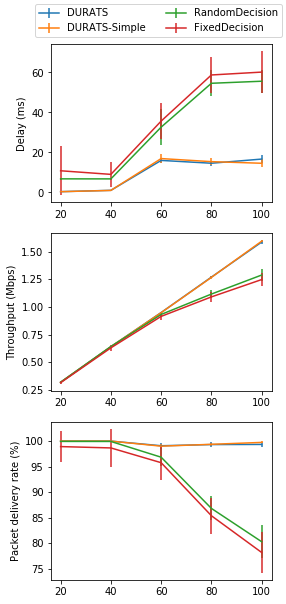

In [2887]:
plotResult2(scenario, subScenarios, nodeInGroupNbr,shiff,[0])

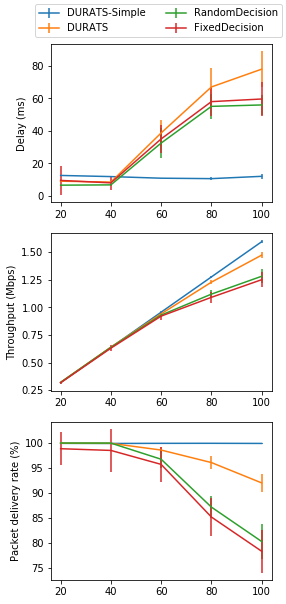

In [2893]:
plotResult2(scenario, subScenarios,nodeInGroupNbr,shiff,[1])

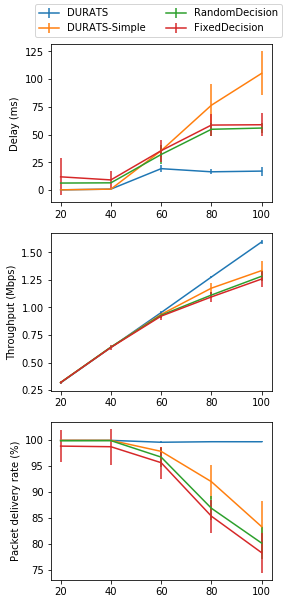

In [2890]:
plotResult2(scenario, subScenarios,nodeInGroupNbr,shiff,[2])